# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Project Overview, Problem Statement, and Metrics

Project Overview:
The goal of this project is to determine what demographic groups are more likely to respond to offers such as advertisements, discount coupons and buy one get one free (BOGO) offers for Starbucks. This projected uses simplified data which assumes all transactions are for the same product vs. the dozens actualy for sale at Starbucks. Ideally if we could predict which customers are morely likely to complete a BOGO or discount offer we could use this imformation to help generate more sales and increase revenue. 

Problem Statement:
In this project we are given a dataset of roughly 306,000 transactions over some time period along with two other datasets which allow us to map each transaction to a user of the app and an offer id. Each dataset contains several pieces of information about the offers and the users. We combine the datasets and after cleaning, preprocessing and exploring our data with visualzations we will train and compare several classification models. We train a KNN classifier, logistic regression, random forest, catboost ensemble and xgboost ensemble and evaluate the classification report and feature import of each.

Metrics:
In this dataset we want to focus on the precision, recall and f1-score (which is the harmonic mean of precision and recell) for evaluation our model. The classification target "Offer Success" is highly imbalanced so these metrics are preferred over accuracy. 


In [2]:
portfolio = pd.read_json('//Users/Ryan/Desktop/Starbucks_Project/portfolio.json', orient='records', lines=True)
profile = pd.read_json('//Users/Ryan/Desktop/Starbucks_Project/profile.json', orient='records', lines=True)
transcript = pd.read_json('//Users/Ryan/Desktop/Starbucks_Project/transcript.json', orient='records', lines=True)

Below is an overview of the datasets used for this analysis:

portfolio.json  

id (string) - offer id  
offer_type (string) - type of offer ie BOGO, discount, informational  
difficulty (int) - minimum required spend to complete an offer  
reward (int) - reward given for completing an offer  
duration (int) - time for offer to be open, in days  
channels (list of strings)  

profile.json  

age (int) - age of the customer  
became_member_on (int) - date when customer created an app account  
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)  
id (str) - customer id  
income (float) - customer's income  

transcript.json  

event (str) - record description (ie transaction, offer received, offer viewed, etc.)  
person (str) - customer id  
time (int) - time in hours since start of test. The data begins at time t=0  
value - (dict of strings) - either an offer id or transaction amount depending on the record  


### Below we will take a look at our datasets and view their shapes

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
portfolio.shape

(10, 6)

In [7]:
profile.shape

(17000, 5)

In [8]:
transcript.shape

(306534, 4)

In [9]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## Cleaning data and preparing for inference and modeling

In the following cells we complete the below steps to prepare the data for inference and modeling:

1. Extract offer ids from the value column with dictionary data
2. Merge transcript data to portfolio using the offer ids
3. Merge to the profile data using person ids
4. Explore missing values and the data distributions of each column with missing values

In [10]:
def find_offer_id(offer_dict):
    """
    This function is used for extractining the offer ids from the offer id dictionaries found in the 
    value column of the transcript data frame
    """
    
    if offer_dict.get('offer id') == None:
        offer_id = offer_dict.get('offer_id')
    else:
        offer_id = offer_dict.get('offer id')
    
    return offer_id
        

In [11]:
transcript['offer_id'] = transcript['value'].apply(lambda x: find_offer_id(x))

In [12]:
transcript.groupby('offer_id')['event'].count()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
2906b810c7d4411798c6938adc9daaa5    15767
3f207df678b143eea3cee63160fa8bed    11761
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
5a8bc65990b245e5a138643cd4eb9837    14305
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
ae264e3637204a6fb9bb56bc8210ddfd    18062
f19421c1d4aa40978ebb69ca19b0e20d    19131
fafdcd668e3743c1bb461111dcafc2a4    20241
Name: event, dtype: int64

In [13]:
transcript.isnull().sum()

person           0
event            0
value            0
time             0
offer_id    138953
dtype: int64

In [14]:
df = transcript.merge(portfolio, how = 'left', left_on = 'offer_id', right_on = 'id')

In [15]:
df = df.merge(profile, how = 'left', left_on = 'person', right_on = 'id')

In [16]:
df.head()

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,id_x,gender,age,id_y,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [17]:
df = df.drop(columns=['id_x', 'id_y'])

In [18]:
df.shape

(306534, 14)

In [19]:
df.isnull().sum()

person                   0
event                    0
value                    0
time                     0
offer_id            138953
reward              138953
channels            138953
difficulty          138953
duration            138953
offer_type          138953
gender               33772
age                      0
became_member_on         0
income               33772
dtype: int64

In [20]:
display(df[(~df['offer_id'].isnull()) & (df['event'] == 'transaction')])

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income


In [21]:
df = df[df['event'] != 'transaction']

In [22]:
df.isnull().sum()

person                  0
event                   0
value                   0
time                    0
offer_id                0
reward                  0
channels                0
difficulty              0
duration                0
offer_type              0
gender              18776
age                     0
became_member_on        0
income              18776
dtype: int64

In [23]:
len(df[df['age'] == 118])

18776

In [24]:
# View the amount of null values in each column as a percentage

[df.isnull().sum()/ len(df)] 

[person              0.000000
 event               0.000000
 value               0.000000
 time                0.000000
 offer_id            0.000000
 reward              0.000000
 channels            0.000000
 difficulty          0.000000
 duration            0.000000
 offer_type          0.000000
 gender              0.112041
 age                 0.000000
 became_member_on    0.000000
 income              0.112041
 dtype: float64]

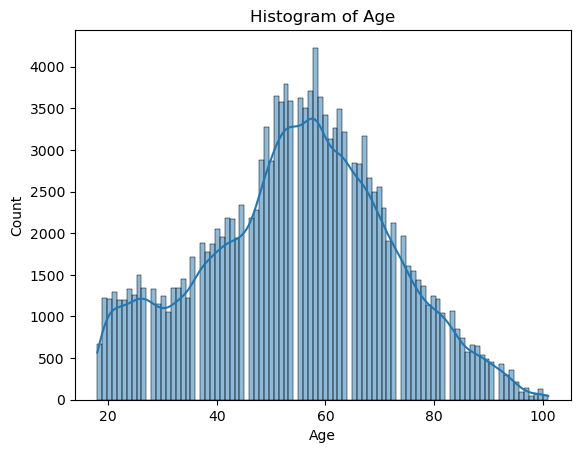

In [25]:
# Plotting the histogram
sns.histplot(df[df['age'] < 110]['age'], kde=True)

# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age')

# Displaying the plot
plt.show()

In [26]:
df[df['age'] < 110]['age'].describe()

count    148805.000000
mean         54.779282
std          17.193533
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         101.000000
Name: age, dtype: float64

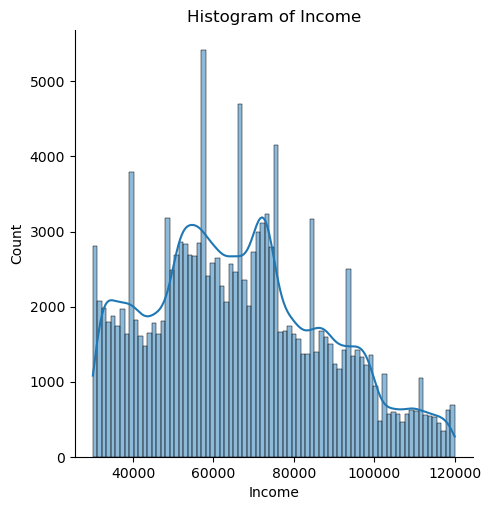

In [27]:
# Plotting the histogram
sns.displot(df['income'].dropna(), kde=True)

# Adding labels and title
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Histogram of Income')

# Displaying the plot
plt.show();

In [28]:
df['income'].dropna().describe()

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64

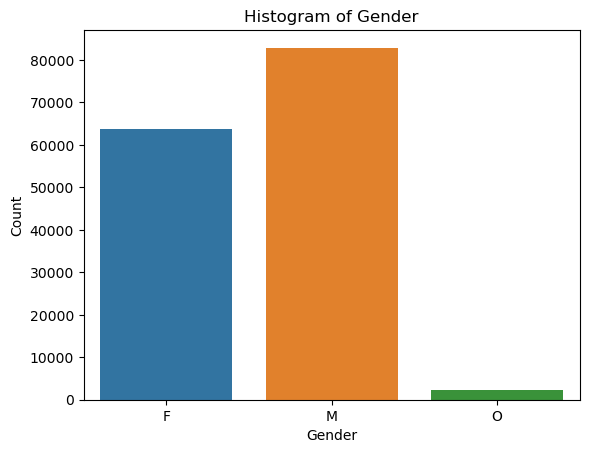

In [29]:
# Plotting the histogram
sns.countplot(data=df, x='gender')

# Adding labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Histogram of Gender')

# Displaying the plot
plt.show()

## Fill Missing Values

In the below cells we will missing values in the age and income columns with the median and missing
values in the gender column with the mode. We are confident in these choices having visualized the distribution 
of values in each column. We choose the median and mode because we want to keep the underlying distribution of 
the columns in tact.

In [30]:
df['income'].fillna(df['income'].median(), inplace=True)

In [31]:
df['age'] = df['age'].replace(118, df['age'].median())

In [32]:
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [33]:
df.head()

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,M,58,20170804,65000.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,M,58,20170925,65000.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,M,58,20171002,65000.0


## One Hot Encoding Categorical Features

In the below cells we split the channels column into multiple categories: email, mobile, social, and web and we apply one hot encoding to these columns and the gender column

In [34]:
df_channels = pd.get_dummies(df['channels'].apply(pd.Series).stack()).sum(level=0)

In [35]:
df_channels.head()

,email,mobile,social,web
0,1,1,0,1
1,1,0,0,1
2,1,1,0,1
3,1,1,1,1
4,1,1,1,1


In [36]:

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df['gender'])
offer_type_encoded = pd.get_dummies(df['offer_type'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded, offer_type_encoded, df_channels], axis=1)

# Drop the original gender column
df_encoded.drop(['gender','channels'], axis=1, inplace=True)

In [37]:
df_encoded.head()

,person,event,value,time,offer_id,reward,difficulty,duration,offer_type,age,...,F,M,O,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,75,...,1,0,0,1,0,0,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,58,...,0,1,0,0,1,0,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,68,...,0,1,0,0,1,0,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,58,...,0,1,0,0,1,0,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,58,...,0,1,0,1,0,0,1,1,1,1


### View the distrubtion of the target column create Offer_Success the final target column for prediction

In [38]:
df_encoded.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [39]:
df_encoded.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [40]:
df_encoded['Offer_Success'] = [1 if event == 'offer completed' else 0 for event in df['event']]

In [41]:
df_encoded.Offer_Success.value_counts()

0    134002
1     33579
Name: Offer_Success, dtype: int64

In [42]:
df_encoded.groupby('offer_type')['Offer_Success'].value_counts(normalize=True)

offer_type     Offer_Success
bogo           0                0.781211
               1                0.218789
discount       0                0.743769
               1                0.256231
informational  0                1.000000
Name: Offer_Success, dtype: float64

### In the above cell we can see that are classes are highly imbalanced with only 22% of bogo offers being successful and only 25.5% of discount offers being successful. This is very important to notice and we must account for this during the modeling portion. We also notice that the informational offer type has 100% non success so we will remove this data from our dataset prior to model building.

In [43]:
df_encoded.columns

Index(['person', 'event', 'value', 'time', 'offer_id', 'reward', 'difficulty',
       'duration', 'offer_type', 'age', 'became_member_on', 'income', 'F', 'M',
       'O', 'bogo', 'discount', 'informational', 'email', 'mobile', 'social',
       'web', 'Offer_Success'],
      dtype='object')

In [44]:
data = df_encoded[(df_encoded['offer_type'] == 'bogo') | (df_encoded['offer_type'] == 'discount')]

In [45]:
data.columns

Index(['person', 'event', 'value', 'time', 'offer_id', 'reward', 'difficulty',
       'duration', 'offer_type', 'age', 'became_member_on', 'income', 'F', 'M',
       'O', 'bogo', 'discount', 'informational', 'email', 'mobile', 'social',
       'web', 'Offer_Success'],
      dtype='object')

## Data Visualization

In the below cells we will visualize the frequency of offer success based on bins of the columns of income and age and categories of the gender columns. We do this to develop inference about what features may have strong predictive importance.

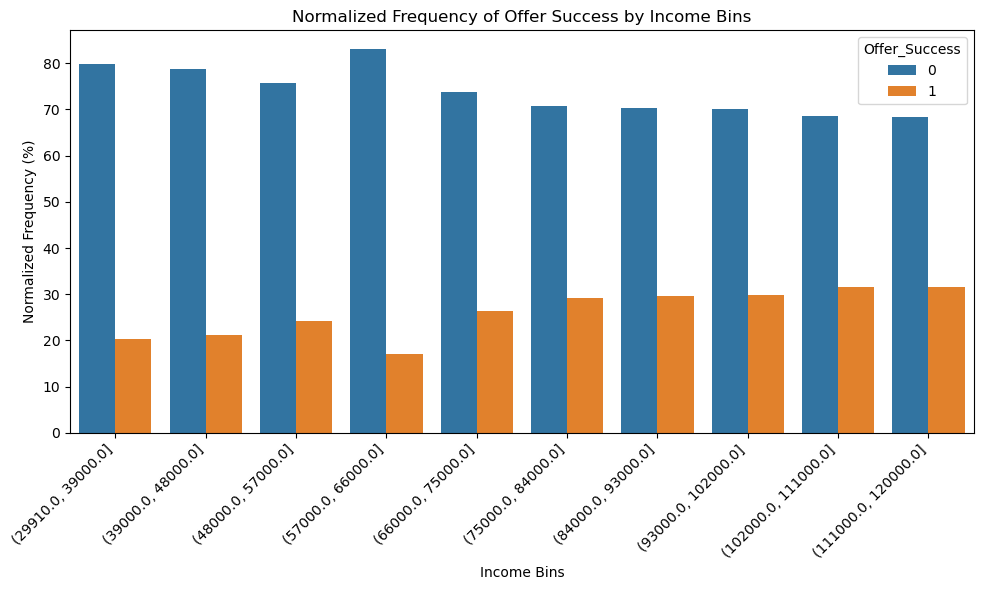

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'data' with columns 'age' and 'Offer Success'

# Create age bins
data['income_bins'] = pd.cut(data['income'], bins=10)

# Calculate the normalized frequency
normalized_freq = data.groupby('income_bins')['Offer_Success'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

# Plot the normalized frequency using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='income_bins', y='Percentage', hue='Offer_Success', data=normalized_freq)
plt.xlabel('Income Bins')
plt.ylabel('Normalized Frequency (%)')
plt.title('Normalized Frequency of Offer Success by Income Bins')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

While there is not an overly distinct pattern it looks like there is a relationship between increasing income and a higher probability of an offer being a success

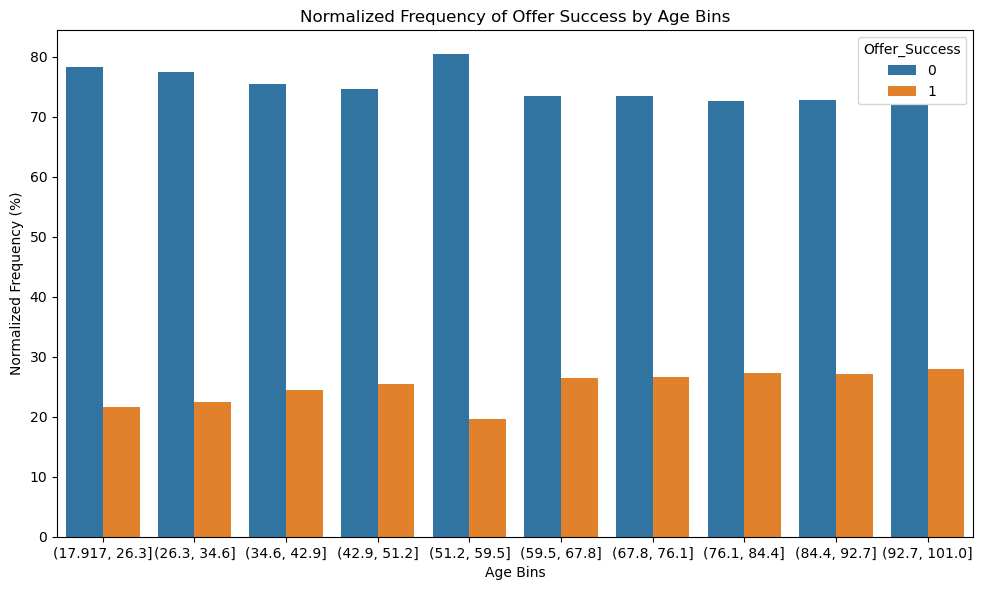

In [47]:
# Assuming you have a DataFrame called 'data' with columns 'age' and 'Offer Success'

# Create age bins
data['age_bins'] = pd.cut(data['age'], bins=10)

# Calculate the normalized frequency
normalized_freq = data.groupby('age_bins')['Offer_Success'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

# Plot the normalized frequency using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='age_bins', y='Percentage', hue='Offer_Success', data=normalized_freq)
plt.xlabel('Age Bins')
plt.ylabel('Normalized Frequency (%)')
plt.title('Normalized Frequency of Offer Success by Age Bins')
plt.tight_layout()
plt.show()

It looks like there is a small increase in frequency of offer success based on age but nothing conclusive regarding the strength of the feature as predictive importance.

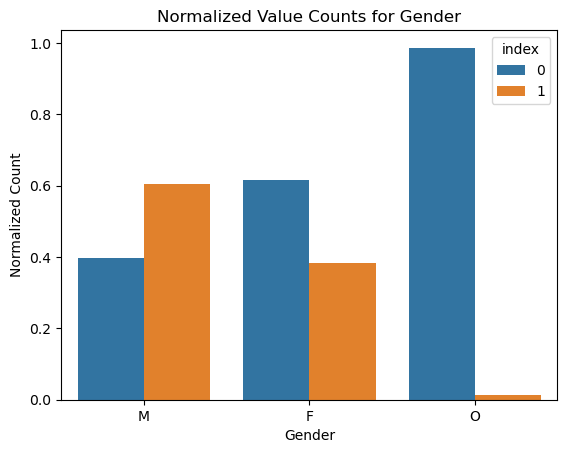

In [48]:
# Assuming you have a DataFrame called 'data' with columns 'M', 'F', and 'O'

# Calculate the normalized value counts
normalized_counts = data[['M', 'F', 'O']].apply(lambda x: x.value_counts(normalize=True))

# Reset the index to convert the result into a DataFrame
normalized_counts = normalized_counts.reset_index()

# Melt the DataFrame to convert it into a long format
normalized_counts = normalized_counts.melt(id_vars='index', var_name='Gender', value_name='Normalized Count')

# Create a bar plot
sns.barplot(data=normalized_counts, x='Gender', y='Normalized Count', hue='index')

# Customize the plot
plt.xlabel('Gender')
plt.ylabel('Normalized Count')
plt.title('Normalized Value Counts for Gender')

# Show the plot
plt.show()

Compared to age and income gender appears to be a much stronger predictive factor!! There clearly a pattern of a much higher percentage of men completing the offers compared to Female and Other. There is also a very low percentage of other gender completing the offers.

## Model Training and Evaluation

In the below cells we will train and 

In [49]:
# Step 1: Split the dataset
knn_df = df_encoded[(df_encoded['offer_type'] == 'bogo') | (df_encoded['offer_type'] == 'discount')]
y = knn_df['Offer_Success']
X = knn_df[['difficulty','duration', 'bogo', 'discount', 'reward', 
            'age', 'income','F',
            'M', 'O', 'email', 'mobile', 'social', 'web']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Identify the minority class
minority_class = knn_df['Offer_Success'].value_counts().idxmin()
print(minority_class)

# Step 3: Perform random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_scaled, y_train)


1


In [50]:
y_train_oversampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: Offer_Success, dtype: float64

In [51]:
# Step 1: Split the dataset into training and testing sets
X_train, y_train = X_train_oversampled, y_train_oversampled
X_test = X_test_scaled

# Step 3: Train the KNN classifier model
k = 5  # Example value for k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Step 4: Validate the model (optional)
# You can use a validation set to tune the hyperparameters, such as k

# Step 5: Assess the performance
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70     21508
           1       0.09      0.09      0.09      6795

    accuracy                           0.55     28303
   macro avg       0.40      0.39      0.40     28303
weighted avg       0.56      0.55      0.55     28303



In [53]:
model = LogisticRegression()
model.fit(X_train_oversampled, y_train_oversampled)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)

# Calculate metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Evaluate the model using a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.5911740804861676
Precision: 0.299462546187437
Recall: 0.5247976453274467
F1-score: 0.38132919852430086
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69     21508
           1       0.30      0.52      0.38      6795

    accuracy                           0.59     28303
   macro avg       0.55      0.57      0.54     28303
weighted avg       0.68      0.59      0.62     28303



In [55]:
feature_names = X.columns.tolist()

### Hyperparameter Tuning the Log Regression Model with GridSearch CV

Note: Originally I want to perform hyperparameter tuning on one of the more powerful models such as catboost or xboost. But my laptop or the Udacity workspace did not have the computational power to finish running the grid search on the xgboost model. As a replacement I demonstrate the usage of Grid search CV to see if we can improve the logistic regression model.

In [56]:
# Define the hyperparameters to tune
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
tuned_y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, tuned_y_pred)

# Calculate metrics
print(f'The best parameters for the logistic regression model are: {best_params}')
print(f' The best model is {best_model}')

accuracy = accuracy_score(y_test, tuned_y_pred)
precision = precision_score(y_test, tuned_y_pred)
recall = recall_score(y_test, tuned_y_pred)
f1 = f1_score(y_test, tuned_y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Evaluate the model using a classification report
report = classification_report(y_test, tuned_y_pred)
print("Classification Report:\n", report)

The best parameters for the logistic regression model are: {'C': 1, 'penalty': 'l2'}
 The best model is LogisticRegression(C=1)
Accuracy: 0.5911740804861676
Precision: 0.299462546187437
Recall: 0.5247976453274467
F1-score: 0.38132919852430086
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69     21508
           1       0.30      0.52      0.38      6795

    accuracy                           0.59     28303
   macro avg       0.55      0.57      0.54     28303
weighted avg       0.68      0.59      0.62     28303



Looking at the accuracy measures above it looks like even after hyperparameter tuning we cannot improve the out of sample test performance of the log regression model!

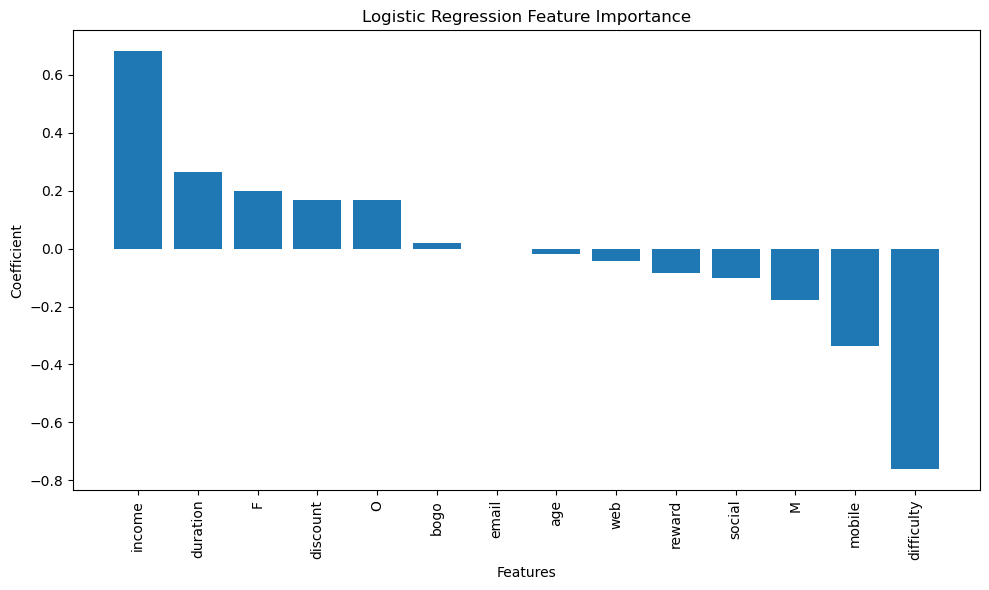

In [57]:
# Assuming you have already trained your logistic regression model and stored it in the variable 'model'
# Assuming you have already prepared your feature names and stored them in the variable 'feature_names'


# Get the coefficients from the model
coefficients = model.coef_[0]

# Sort the coefficients in descending order
sorted_indices = np.argsort(coefficients)[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Logistic Regression Feature Importance')
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.51      0.58     21508
           1       0.13      0.22      0.16      6795

    accuracy                           0.44     28303
   macro avg       0.40      0.37      0.37     28303
weighted avg       0.54      0.44      0.48     28303



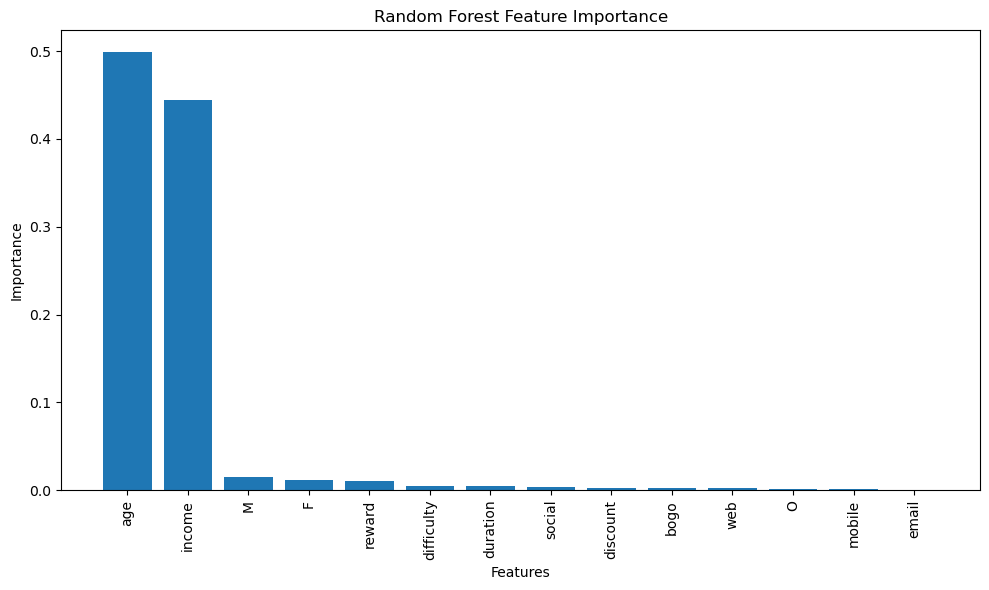

In [58]:
# Assuming you have already split your dataset into X_train, X_test, y_train, and y_test

# Fit a Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Visualize feature importance
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [62]:
#from catboost import CatBoostClassifier
#from sklearn.metrics import classification_report
#import matplotlib.pyplot as plt

# Assuming you have already split your dataset into X_train, X_test, y_train, and y_test

# Fit a CatBoost Classifier
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train);

# Predict on the test set
catboost_y_pred = model.predict(X_test);



Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.42      0.56     21508
           1       0.27      0.68      0.39      6795

    accuracy                           0.48     28303
   macro avg       0.54      0.55      0.47     28303
weighted avg       0.68      0.48      0.52     28303



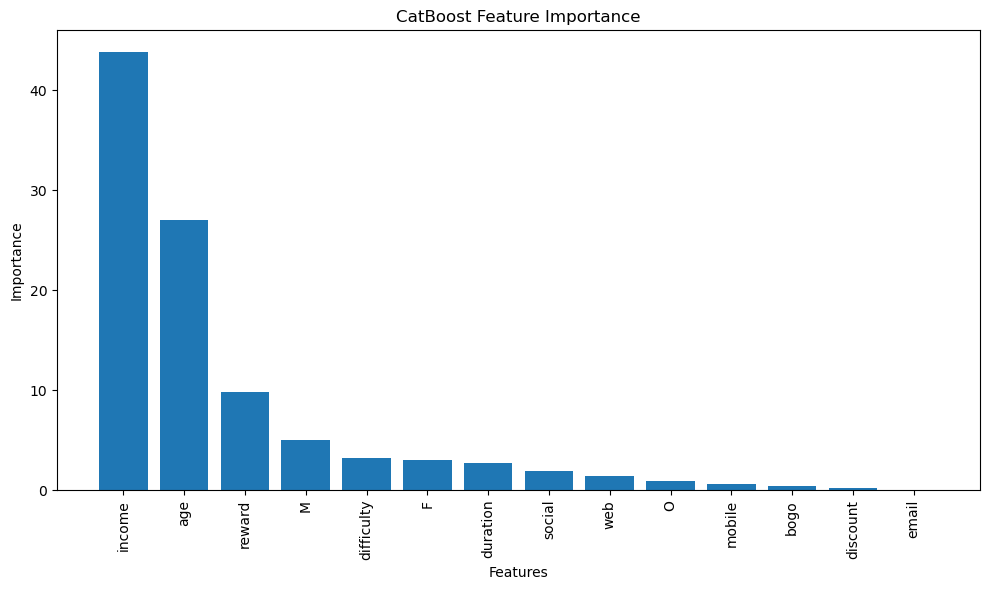

In [63]:
# Evaluate the model using a classification report
report = classification_report(y_test, catboost_y_pred)
print("Classification Report:\n", report)

# Visualize feature importance
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.44      0.56     21508
           1       0.26      0.64      0.37      6795

    accuracy                           0.48     28303
   macro avg       0.53      0.54      0.47     28303
weighted avg       0.67      0.48      0.52     28303



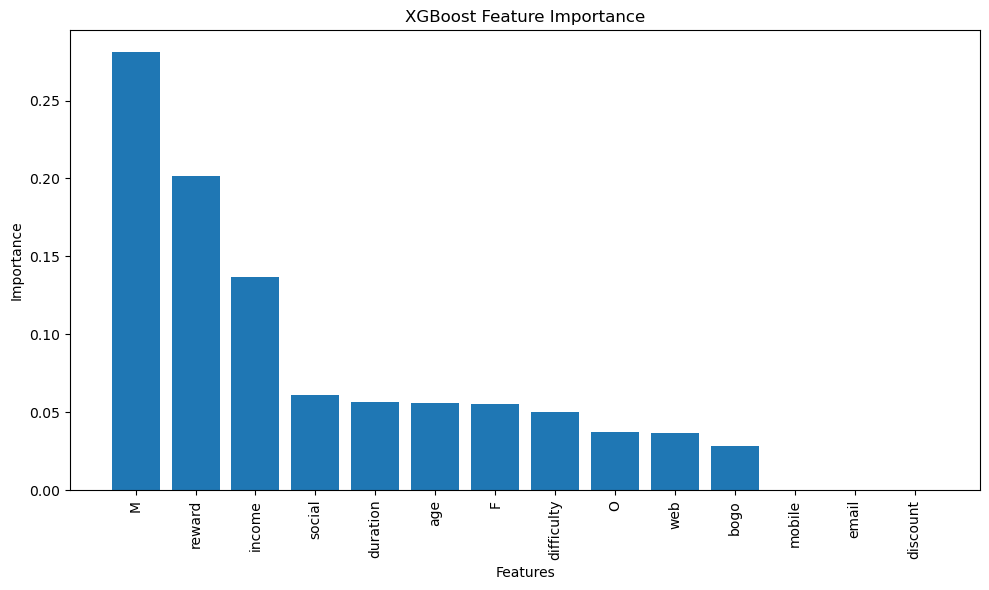

In [61]:
from xgboost import XGBClassifier

# Assuming you have already split your dataset into X_train, X_test, y_train, and y_test

# Fit an XGBoost Classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Visualize feature importance
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

## Model Evaluation

In the above cells we fit five different models to the oversampled and min max scaled training data, tested the models on the out of sample testing data, calculated and visualized the performance metrics and visualized the feature importance. Using weighted avg and macro avg f1 score for both the 0 (offer not completed) and 1 (offer completed) categories we find that the grid search CV hyperparameter tuned logistic regression model performs the best out of sample! This is actually quite surprising as I would have expected the catboost and xgboost models to perform much better even without hyper parameter tuning. This is something to improve on as I will discuss in the next section. 

Overall I am disappointed in the results as for any of the models we are not able to score a weighted avg f1 score over .62. Ideally we would like to be able to obtain a f1 score of .80 or higher. The way our project and analysis is correctly structed the imbalance in the dataset is causing significant problems.

## Conclusion

1. Reflection
While our modeling performance is not able to meet expectations we can still draw some business conclusions from our analysis. First of all I want to emphasize the visuals of normalized offer success frequency based on income, age and gender. We can conclude from this analysis that based on our sample higher income leads to a higher rate of offer success and that men are more likely to complete their offers then women. We can also see this being confirmed in the feature importance of the xgboost model which shows M, reward, and income as the most impactful features.

2. Improvement
Here are what I believe are the most important things we could do to improve our modeling performance and the significance of the business conclusions we are able to make:

        1. Access to more computing power for the hyperparamenter tuning and grid search of the catboost and xgboost models.
        2. Collect more data specifically for the offer success class to help with class imbalanced.
        
        3. Gather more data about our users and perform feature engineering to improve the performance of our models.
        
I think with this project we have a very good start with this data set and by performing the above steps we could take our performance to the next level and hopefully obtain a f1 score of .80 or higher!